# Restriction Spectrum Sparse Fascicle Model

This notebook demonstrates the fitting of the RS-SFM model to the data from one voxel.

We start by importing general python tools for analysis and visualization. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

We use the [`scikit-learn`](http://scikit-learn.org) implementation of the Elastic Net algorithm

In [2]:
import sklearn.linear_model as lm

We use functions from [`dipy`](http://dipy.org) to calculate model goodness-of-fit, and to represent the gradient table:

In [3]:
from dipy.reconst.cross_validation import coeff_of_determination
from dipy.core import gradients as grad

Finally, we import the local utility functions for this data set, as  well as our implementation of the RS-SFM model (which extends the implementation that exists in `dipy`)

In [4]:
import utils
from model import Model, BiExponentialIsotropicModel

A utility function reads the data from the files:

In [5]:
data = utils.read_data()

The next cell can be changed to choose data from another voxel (there are 6 voxels from each one of the ROIs). 

In [6]:
vox_idx = 0

The fornix ROI can be chosen by changing `seen` to `seenX` in the following cell

In [7]:
signal = data['seen']['signal'][:, vox_idx]
bvals = data['seen']['bvals']
bvecs = data['seen']['bvecs']
delta = data['seen']['delta']
Delta = data['seen']['Delta']
te = data['seen']['TE']
g = data['seen']['g']

This is the measurement gradient table (b-values and b-vectors)

In [8]:
gtab = grad.gradient_table(bvals, 
                           bvecs, 
                           big_delta=Delta, 
                           small_delta=delta)

The following sets up the model, specifying the measurement scheme (`gtab`), as well as the model of the isotropic signal (`BiExponentialIsotropicModel`) and the `ElasticNet` solver parameters:

In [9]:
model = Model(gtab, 
              isotropic=BiExponentialIsotropicModel, 
              solver=lm.ElasticNet(l1_ratio=0.4, 
                                   alpha=5e-7, 
                                   positive=True, 
                                   warm_start=True, 
                                   fit_intercept=True, 
                                   normalize=True))

We fit the model with the signal provided for this voxel, and with TE and G, used to fit T2 effects, and to weight the measurements

In [10]:
fit = model.fit(signal, te, g)

/Users/arokem/anaconda3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:490: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


We predict back the signal using the derived model parameters

In [11]:
predict = fit.predict(gtab, te)

The first visualization provides an overall sense of the goodness of fit, and calculates the coefficient of determination ($R^2$) of the fit

R-squared = 98.7782008714


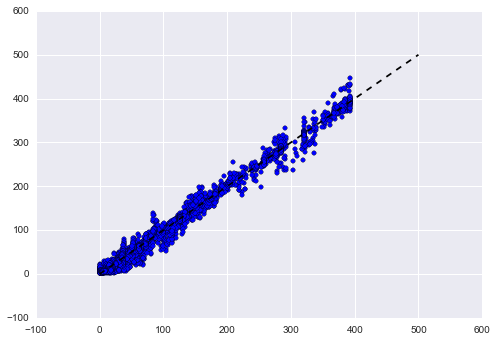

In [12]:
fig, ax = plt.subplots(1)
plt.scatter(predict, signal)
plt.plot([0, 500], [0, 500], 'k--')
print('R-squared = %s'%coeff_of_determination(signal, predict))

The next visualization examines the fit in different gradient strength settings. Each plot corresponds to a gradient strength range. Data is plotted so that the signal measured is on the left side of each plot, and the signal predicted is on the right side. The data are plotted as a function of the angle of the direction of the diffusion gradient for each data-point, relative to the sagittal direction ([1, 0, 0]). Different color points in each figure come from measurements with different diffusion weighting strength (b-value).

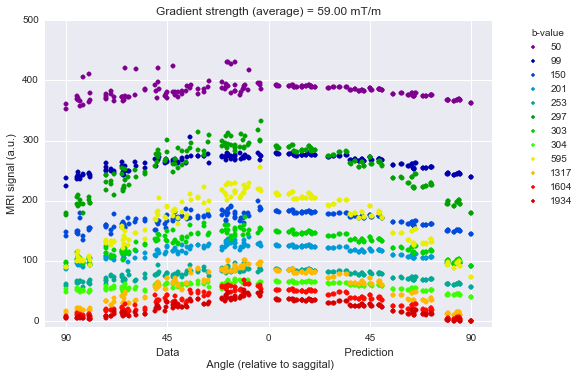

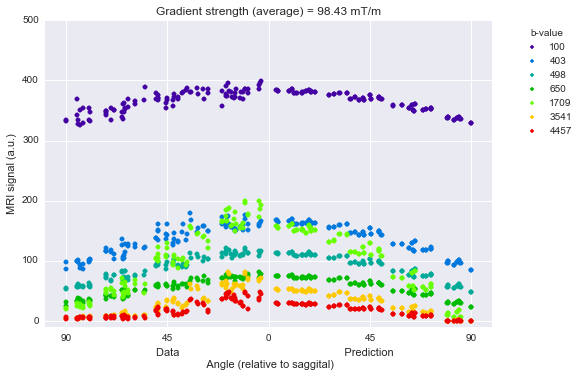

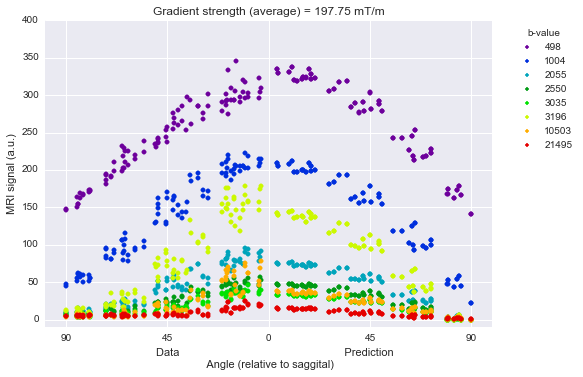

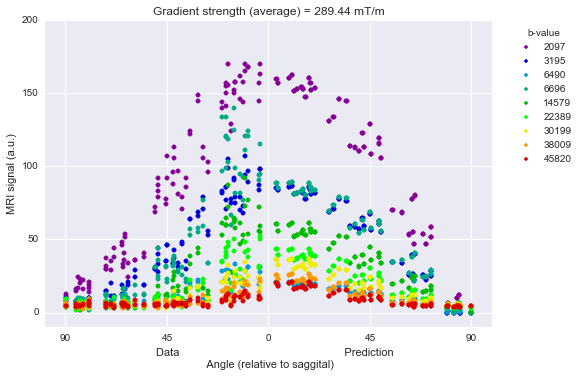

In [13]:
g_tiers = [0, 85, 185, 265, 350]
g_labels = []
for g_group in range(len(g_tiers)-1):
    g_idx = np.where(np.logical_and(g > g_tiers[g_group], g < g_tiers[g_group+1]))
    this_predict = predict[g_idx]
    this_signal = signal[g_idx]
    this_bvec = bvecs[g_idx]
    this_bval = bvals[g_idx]
    x = []
    y1 = []
    y2 = []
    b = []
    for idx, bv in enumerate(this_bvec):
        if this_bval[idx]>0:
            x.append(np.abs(np.dot(bv, [1, 0, 0])))    
            b.append(this_bval[idx])
            y1.append(this_predict[idx])
            y2.append(this_signal[idx])        
        
    fig, ax = plt.subplots(1)
    pal = np.array(sns.color_palette(name='spectral', n_colors=len(np.unique(b))))
    for ii, bb in enumerate(np.unique(b)):
        bb_idx = np.where(b==bb)
        ax.scatter(np.array(x)[bb_idx], np.array(y1)[bb_idx], color=pal[np.mod(ii, len(pal))])
        ax.scatter(-np.array(x)[bb_idx], np.array(y2)[bb_idx], color=pal[np.mod(ii, len(pal))])
        # This one's just so we can get a nice legend:
        ax.plot(-1.2, 0, '.', color=pal[np.mod(ii, len(pal))], label='%s'%np.int(bb))
    
    ax.set_xlabel('    Data                                                       Prediction\n Angle (relative to saggital)')
    ax.set_ylabel('MRI signal (a.u.)')
    ax.set_ylim([-10, None])
    ax.set_xlim([-1.1, 1.1])
    ax.set_xticklabels([0, 90, 45, 0, 45, 90])
    ax.set_title('Gradient strength (average) = %3.2f mT/m'%np.mean(g[g_idx]))
    plt.legend(loc=1,bbox_to_anchor=(1.2, 1), title='b-value')